In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
sys.path.insert(0, '..')
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.image import ResizeMethod
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K

from models.deepnetwork.converters.keras import convert
from models.deepnetwork.core.intermediate import DeepNetwork

# Dlib bug
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


## Test Latex Compiler

In [2]:
from PIL import Image
from pylatex import Document, NoEscape, SmallText, Command
from pdf2image import convert_from_path
from pylatex.base_classes.command import Options

print(Command('documentclass',
         options=Options('12pt', 'a4paper', 'twoside'),
         arguments='article').dumps())

def render_latex(latex):
    """Render Latex code to an image"""
    filename = "jupyter_tmp"
    doc = Document(filename, documentclass='standalone', page_numbers=False)
    doc.preamble.append(Command('usepackage', 'amsmath'))
    doc.append(SmallText(NoEscape(latex)))
    try:
        doc.generate_pdf(filename, clean_tex=False)
    except Exception as e:
        print("Silent Error")
    images = convert_from_path(filename + '.pdf')
    # Remove temporary files
    if os.path.exists(filename + '.pdf'):
        os.remove(filename + '.pdf')
    if os.path.exists(filename + '.aux'):
        os.remove(filename + '.aux')
    if os.path.exists(filename + '.tex'):
        os.remove(filename + '.tex')
    return images[0]

render_latex(r"hello $\alpha$")

\documentclass[12pt,a4paper,twoside]{article}


## Loading Resized Dataset

In [3]:
def ResizeLayer(input_shape, output_shape):
    output_tensor_shape = (output_shape[0], output_shape[1], 1)
    return keras.layers.Lambda( 
        lambda image: tf.image.resize_images( 
            image, 
            output_shape,
            method = tf.image.ResizeMethod.BICUBIC,
            align_corners = True, # possibly important
            preserve_aspect_ratio = True
        ), output_shape=output_tensor_shape
    )


#  Reload the data before we make the images smaller
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28
img_resize_rows, img_resize_cols = 14, 14

# Reshape the matrices
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# Make images smaller
input_shape = (img_rows, img_cols)
image_resize = (img_resize_rows, img_resize_cols)
model_input_shape = (img_resize_rows, img_resize_cols, 1)
print("Resizing:", input_shape, "->", image_resize)
print("New model input size: ", model_input_shape)

resize_model = Sequential()
resize_model.add(ResizeLayer(input_shape, image_resize))

num_classes = 10
x_train = resize_model.predict(x_train)
x_test = resize_model.predict(x_test)

# Scale x to the range [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Resizing: (28, 28) -> (14, 14)
New model input size:  (14, 14, 1)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
x_train shape: (60000, 14, 14, 1)
60000 train samples
10000 test samples


## Defining PMML Constants

In [4]:
debug = False 
class_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}

pmml_path = "./models/small_model.pmml"
weights_path = "./models/small_model.h5"
description = "Simple model to detect hand-written digits"

# Check Model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Completed building keras model: Simple model to detect hand-written digits
Loading weights from ./models/small_model.h5... Done


Text(0.5, 1.0, 'Seven')

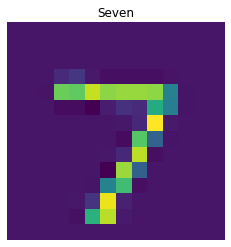

In [5]:
import matplotlib.pyplot as plt

im = x_test[0,:,:]
new_model = DeepNetwork(filename=pmml_path)
prediction = new_model.predict(im)
plt.imshow(np.squeeze(im))
plt.axis("off")
plt.title(prediction)

Text(0.5, 1.0, 'Seven')

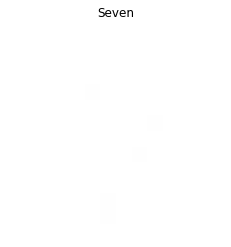

In [6]:
plt.imshow(255-np.squeeze(im), cmap='gray', vmin=0, vmax=255)
plt.axis("off")
plt.title(prediction)

Completed building keras model: Simple model to detect hand-written digits
Loading weights from ./models/small_model.h5... Done


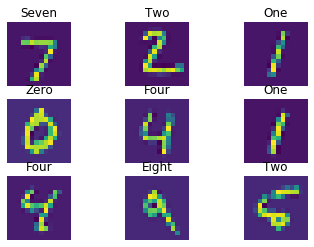

In [7]:
new_model = DeepNetwork(filename=pmml_path)
for i in range(3):
    for j in range(3):
        index = 3*i + j
        im = x_test[index,:,:]
        plt.subplot(3, 3, index+1)
        prediction = new_model.predict(im)
        plt.imshow(np.squeeze(im))
        plt.axis("off")
        plt.title(prediction)

In [8]:
def get_model_output(batch, layernum):
    """Return the output of a the keras_model at a certain layer"""
    get_output = K.function([keras_model.layers[0].input],
                        [keras_model.layers[layernum].output])
    return get_output(batch)

In [9]:
import array_to_latex as latex

def bmatrix(a, squeeze=True, round=False):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    frmt = "{:3.2f}"
    if a.size==1:
        out = "\\begin{bmatrix} \n"
        out += frmt.format(a[0])
        out += "\n \\end{bmatrix}"
        return out
    if squeeze:
        a = np.squeeze(a)
    raw = latex.to_ltx(a, frmt=frmt, arraytype='bmatrix', print_out=False, nargout=1, row=False)
    #raw = raw.replace("begin{bmatrix}", "begin{bmatrix}{*{20}c}")
    #print(raw)
    return raw

In [10]:
keras_model = new_model.get_keras_model()
for layer in keras_model.layers:
    weights = layer.get_weights()
    for w in weights:
        print(layer.name, w.shape)


Completed building keras model: Simple model to detect hand-written digits
Loading weights from ./models/small_model.h5... Done
conv2d_2 (3, 3, 1, 1)
conv2d_2 (1,)
conv2d_3 (3, 3, 1, 1)
conv2d_3 (1,)
dense_2 (25, 16)
dense_2 (16,)
dense_3 (16, 10)
dense_3 (10,)


## Input Layer

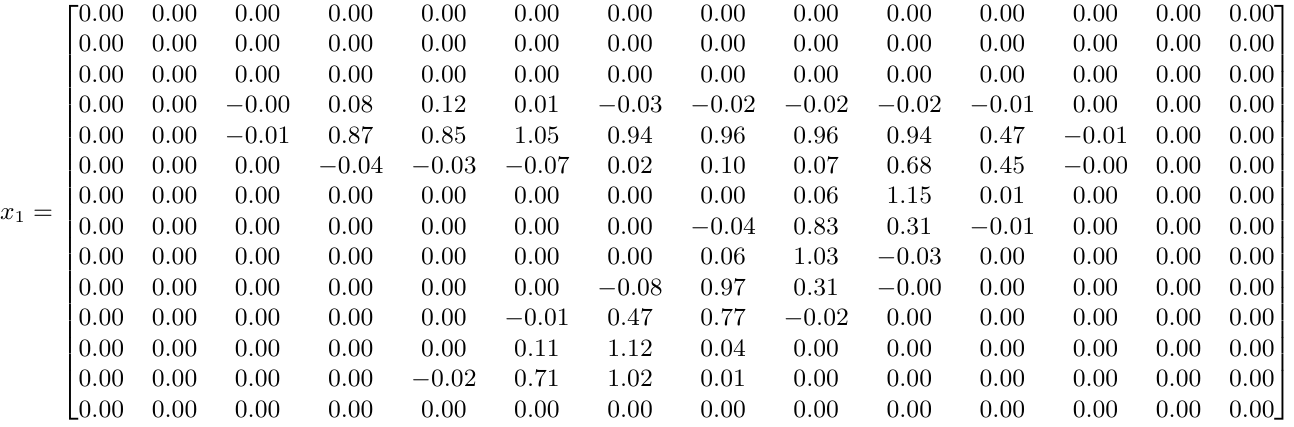

In [11]:
batch = x_test[0:1,:,:]
image = x_test[0,:,:]
layer = keras_model.layers[1]
weights = layer.get_weights()
raw = r"$\setcounter{MaxMatrixCols}{20}" + "\n"
raw += r"\begin{aligned}" + "\n"
raw += "x_1 &= " + bmatrix(image) + "\\\\\n"
raw += r"\end{aligned}$"

img = render_latex(raw)
img.save("../docs/images/input-image.png")
img

## First Convolution Layer

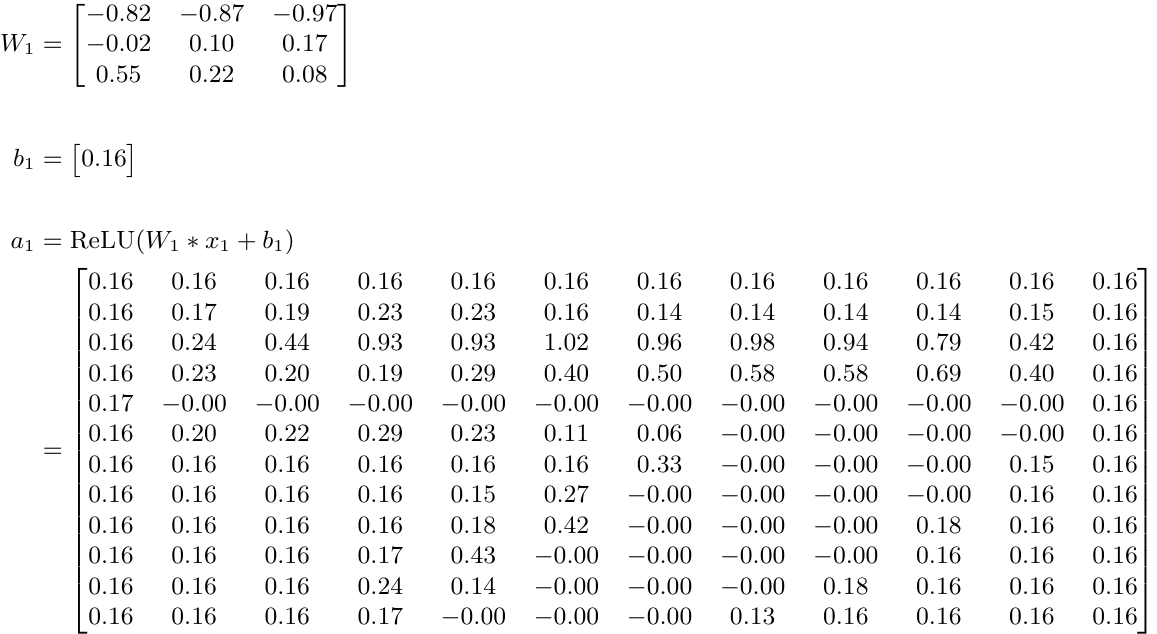

In [12]:
layernum = 1
batch = x_test[0:1,:,:]
image = x_test[0,:,:]
layer = keras_model.layers[layernum]
weights = layer.get_weights()
raw = r"$\setcounter{MaxMatrixCols}{20}" + "\n"
raw += r"\begin{aligned}" + "\n"
#raw += "x_1 &= " + bmatrix(image) + "\\\\\n"
raw += "W_1 &= " + bmatrix(weights[0]) + r"\\ \\" + "\n"
raw += "b_1 &= " + bmatrix(weights[1]) + r"\\ \\" + "\n"
raw += "a_1 &= \\text{ReLU}(W_1 * x_1 + b_1)" + "\\\\\n"
raw += "    &= " + bmatrix(get_model_output(batch, layernum=1)[0]) + "\\\\\n"
raw += r"\end{aligned}$"

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

## Second Convolution Layer

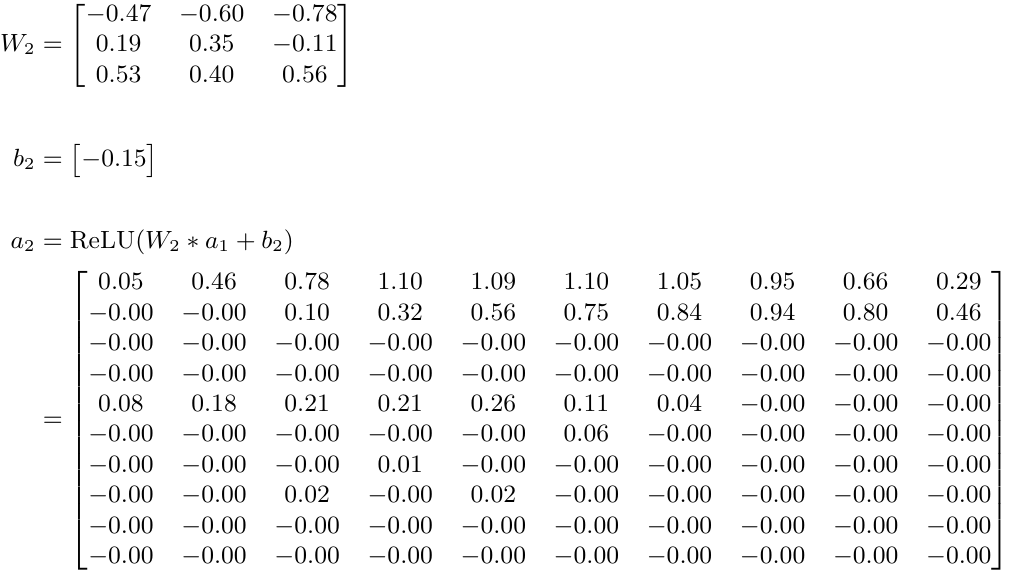

In [13]:
layernum = 2
layer = keras_model.layers[layernum]
weights = layer.get_weights()
raw = r"$\setcounter{MaxMatrixCols}{20}" + "\n"
raw += r"\begin{aligned}" + "\n"
#raw += "x_1 &= " + bmatrix(image) + "\\\\\n"
raw += "W_2 &= " + bmatrix(weights[0]) + r"\\ \\" + "\n"
raw += "b_2 &= " + bmatrix(weights[1]) + r"\\ \\" + "\n"
raw += "a_2 &= \\text{ReLU}(W_2 * a_1 + b_2)" + "\\\\\n"
raw += "    &= " + bmatrix(get_model_output(batch, layernum=2)[0]) + "\\\\\n"
raw += r"\end{aligned}$"

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

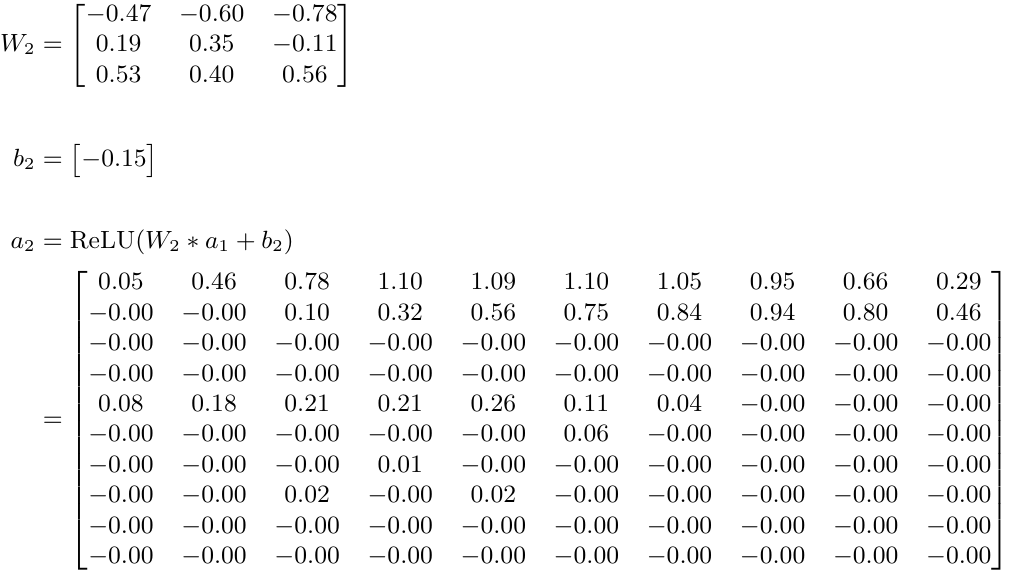

In [14]:
img

## First Max Pooling Layer

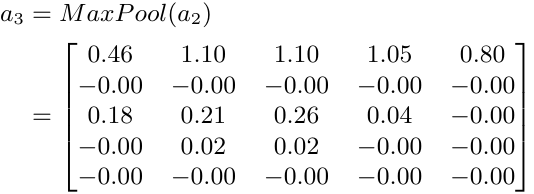

In [15]:
layernum = 3
raw = r"$\begin{aligned}" + "\n"
raw += r"a_3 &= MaxPool(a_2) \\" + "\n"
raw += r"&= " + bmatrix(get_model_output(batch, layernum=3)[0]) + "\n"
raw += r"\end{aligned}$"
#print(raw)

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

## Flatten

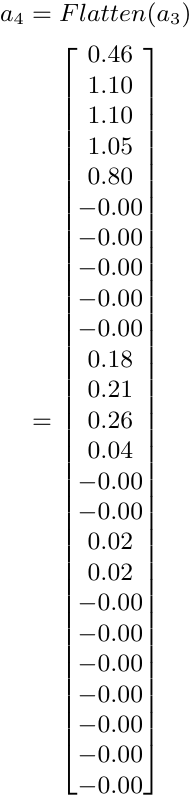

In [16]:
layernum = 4
raw = r"$\begin{aligned}" + "\n"
raw += r"a_4 &= Flatten(a_3) \\" + "\n"
raw += r"&= " + bmatrix(get_model_output(batch, layernum=5)[0]) + "\n"
raw += r"\end{aligned}$"
#print(raw)

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

## First Dense Layer

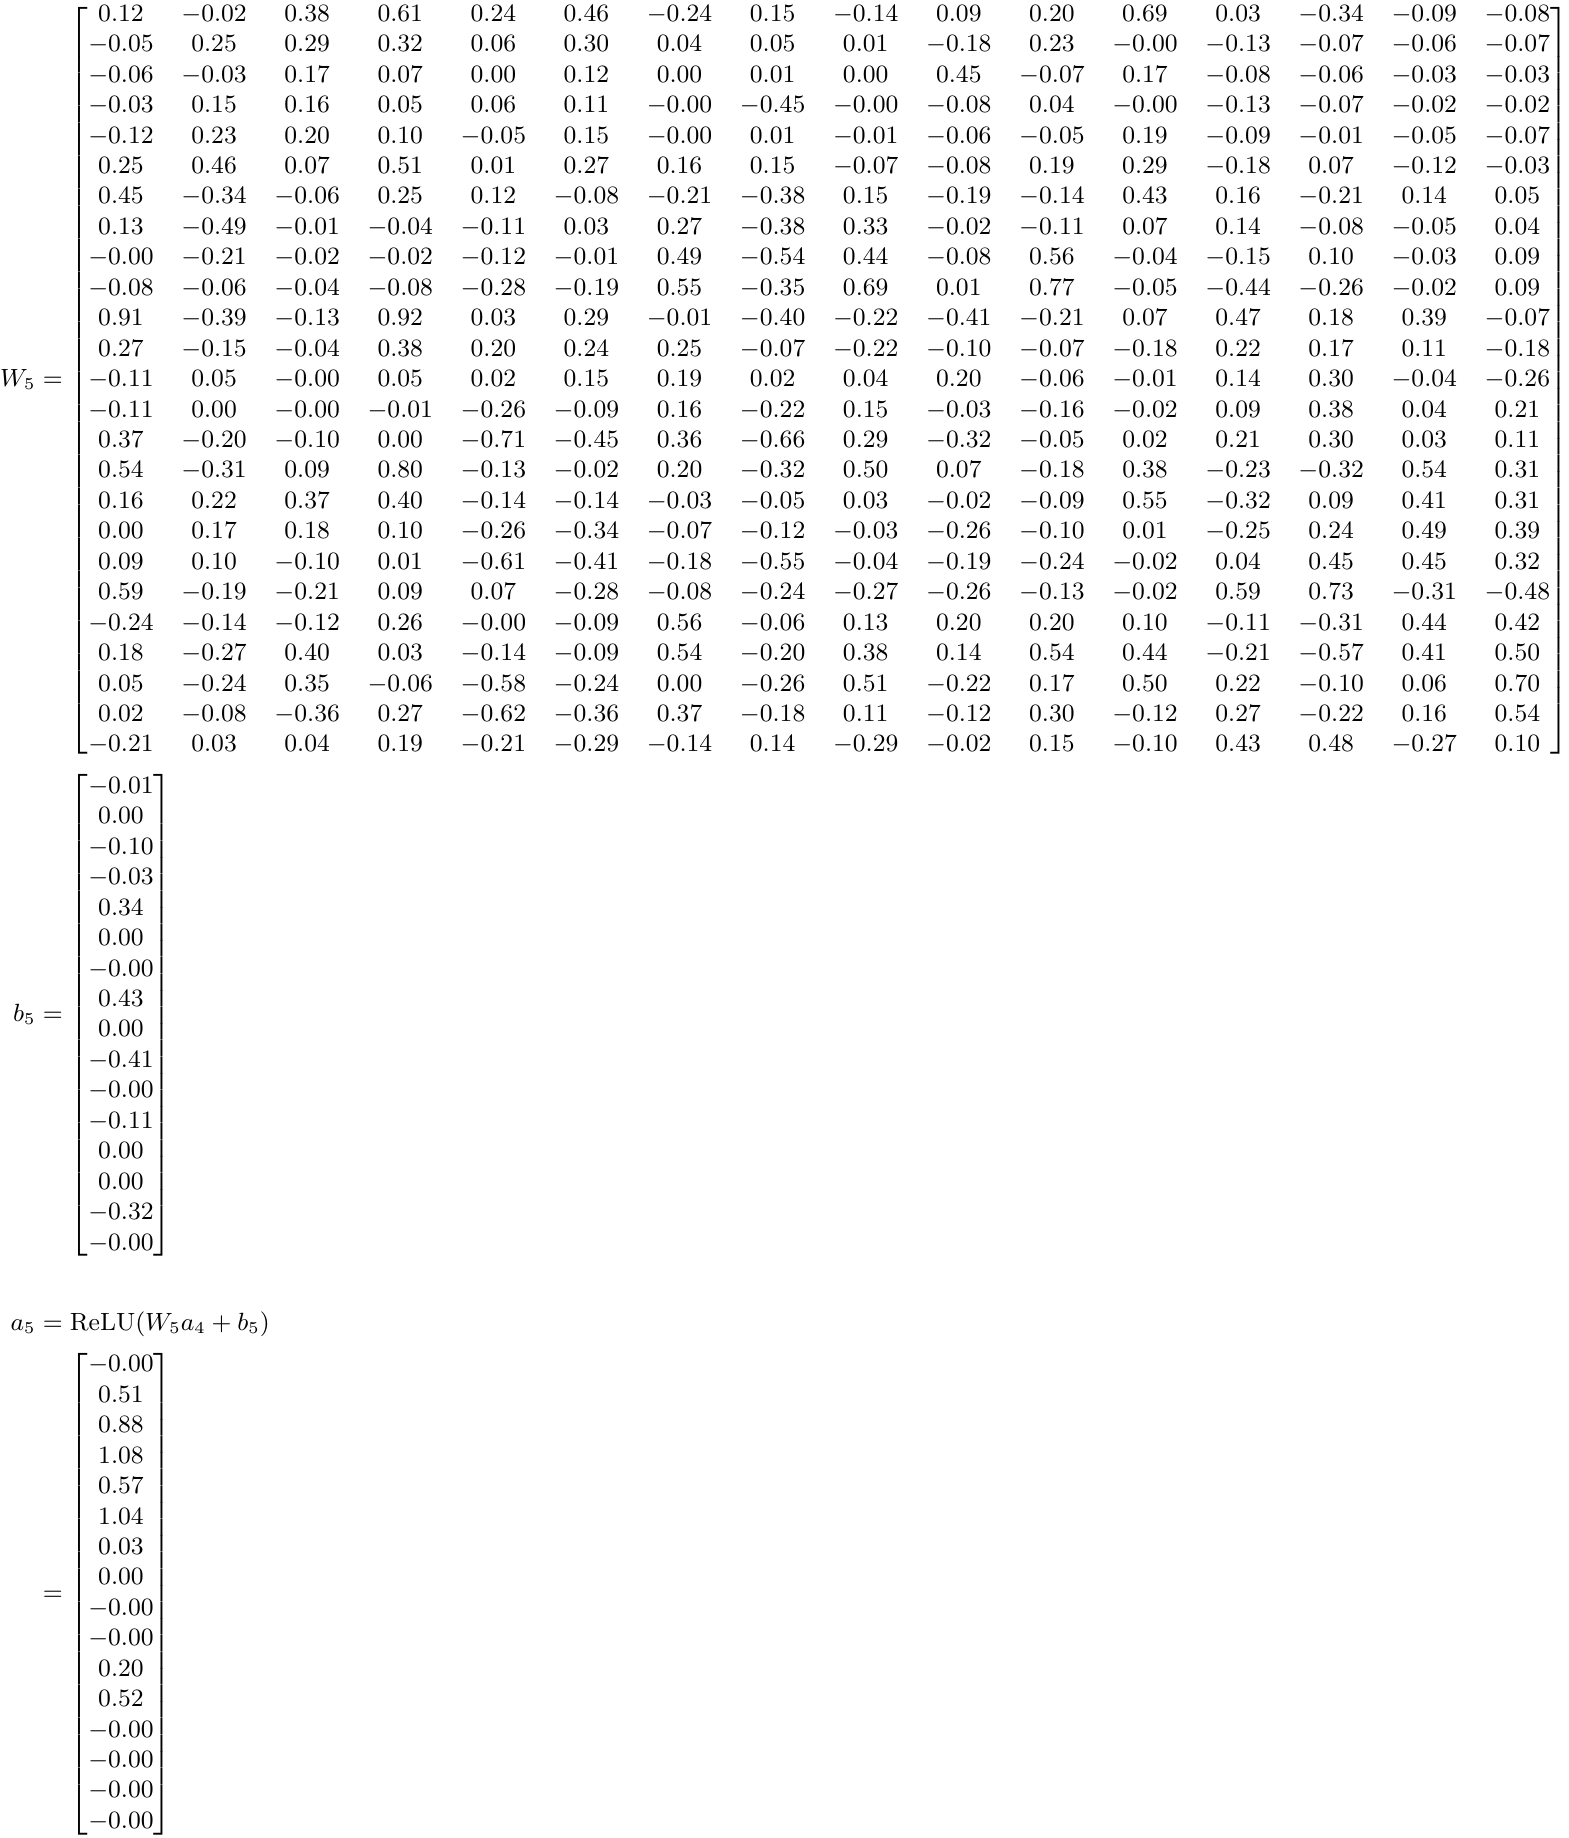

In [17]:
layernum = 6
layer = keras_model.layers[layernum]
weights = layer.get_weights()
raw = r"$\setcounter{MaxMatrixCols}{20}" + "\n"
raw += r"\begin{aligned}" + "\n"
raw += "W_5 &= " + bmatrix(weights[0]) + "\\\\\n"
raw += "b_5 &= " + bmatrix(weights[1]) + r"\\ \\" + "\n"
raw += "a_5 &= \\text{ReLU}(W_5 a_4 + b_5)" + "\\\\\n"
raw += "    &= " + bmatrix(get_model_output(batch, layernum=layernum)[0]) + "\\\\\n"
raw += r"\end{aligned}$"

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

## Second Dense Layer¶

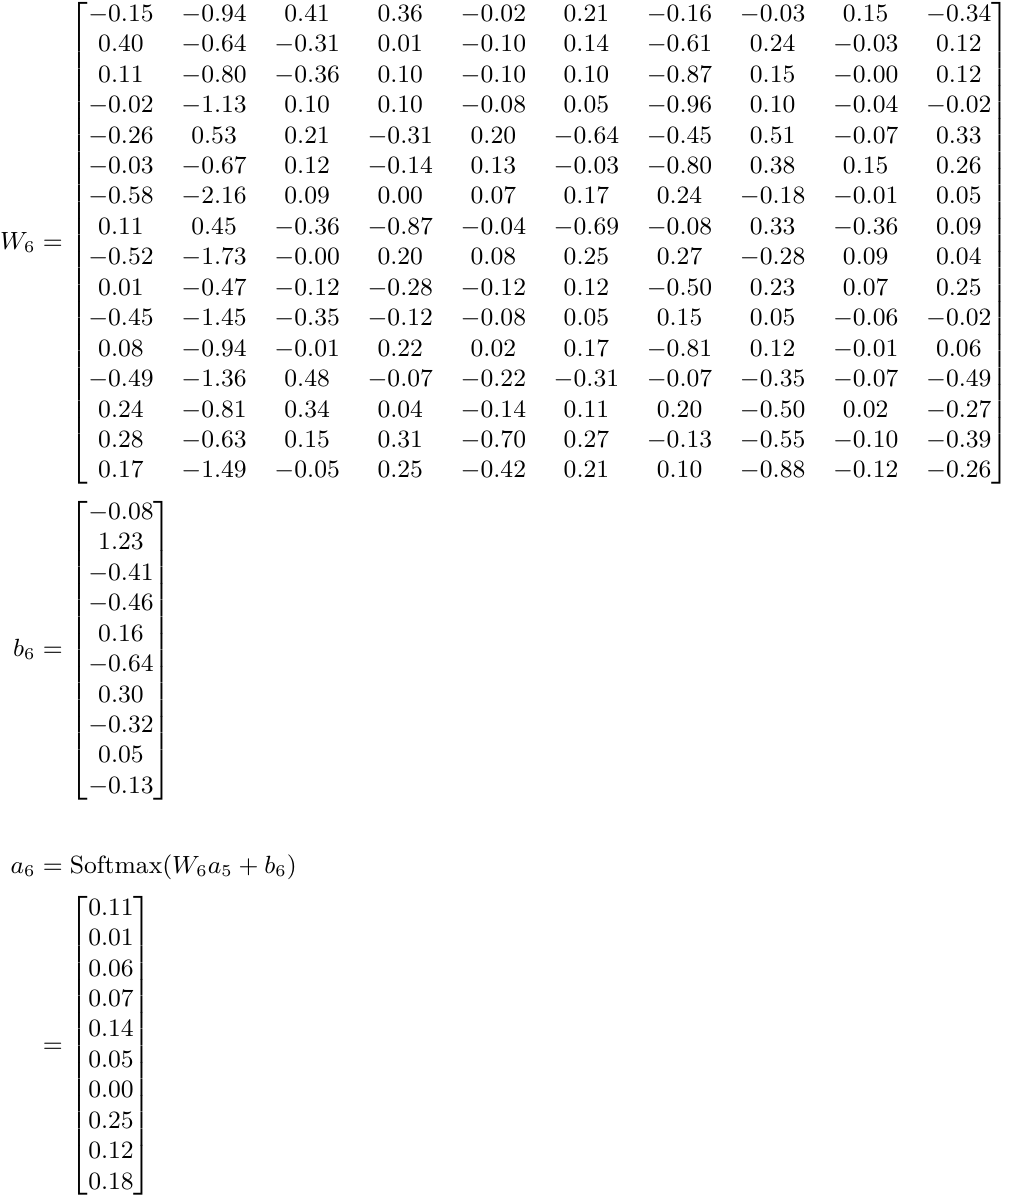

In [18]:
layernum = 8
layer = keras_model.layers[layernum]
weights = layer.get_weights()
output =  get_model_output(batch, layernum=layernum)[0]

raw = r"$\setcounter{MaxMatrixCols}{20}" + "\n"
raw += r"\begin{aligned}" + "\n"
raw += "W_6 &= " + bmatrix(weights[0]) + "\\\\\n"
raw += "b_6 &= " + bmatrix(weights[1]) + r"\\ \\" + "\n"
raw += "a_6 &= \\text{Softmax}(W_6 a_5 + b_6)" + "\\\\\n"
raw += "    &= " + bmatrix(output[0]) + "\\\\\n"
raw += r"\end{aligned}$"

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

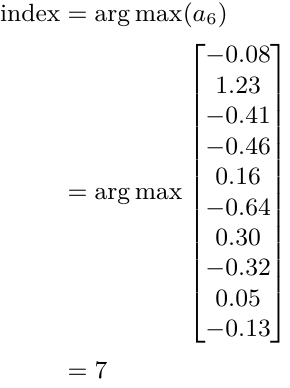

In [19]:
layernum = 9
argmax = np.argmax(output)
raw =  r"$\begin{aligned}" + "\n"
raw += r"\text{index} &= \arg\max (a_6) \\" + "\n"
raw += r"&= \arg\max " + bmatrix(weights[1]) + r"\\" + "\n"
raw += r"&= " + str(argmax) + " \end{aligned}$" + "\n"

img = render_latex(raw)
img.save(f"../docs/images/layer-{layernum}.png")
img

# Weights


In [20]:
from utils.h5json import converter
from tables import open_file

import h5py
import json

data = converter(open_file("models/small_model.h5","r"))
contents = data.to_json()
print(contents)

{
  "/": {},
  "conv2d_2": {
    "bias:0": [
      0.16033408045768738
    ],
    "kernel:0": "<Tensor shape=(3, 3, 1, 1)>"
  },
  "conv2d_3": {
    "bias:0": [
      -0.1472928673028946
    ],
    "kernel:0": "<Tensor shape=(3, 3, 1, 1)>"
  },
  "dense_2": {
    "bias:0": "<Tensor shape=(16,)>",
    "kernel:0": "<Tensor shape=(25, 16)>"
  },
  "dense_3": {
    "bias:0": "<Tensor shape=(10,)>",
    "kernel:0": "<Tensor shape=(16, 10)>"
  },
  "dropout_2": {},
  "dropout_3": {},
  "flatten_1": {},
  "input_2": {},
  "max_pooling2d_1": {}
}
